# Normalizing flows:  re-implementation of the Glow paper

In [1]:
import numpy as np
import tensorflow as tf
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/krzysiek/anaconda3/envs/detection/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import utils
import nets
import flow_layers as fl

In [3]:
tf.set_random_seed(0)
sess = tf.InteractiveSession()

## Import dataset

In [4]:
batch_size = 16
x_train_samples = utils.create_tfrecord_dataset_iterator(
    "datasets/celeba/celeba_test.tfrecords", batch_size=batch_size
)

x_train_samples

<tf.Tensor 'truediv:0' shape=(16, 48, 48, 3) dtype=float32>

### Check shapes (initial call will take a while)

In [5]:
x_train_samples.eval().shape

(16, 48, 48, 3)

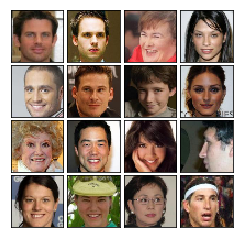

In [7]:
utils.plot_4x4_grid(x_train_samples.eval(), shape=[48, 48, 3])

## Build Flow with Resnet blocks 

In [8]:
nn_template_fn = nets.ResentTemplate(
    units_factor=2, num_blocks=2
)

* the more steps the better. At th begining I have tried with num_steps=1, or 2 but model was not learning at all

In [9]:
layers, actnorm_layers = nets.create_simple_flow(
    num_steps=5, 
    num_scales=4, 
    template_fn=nn_template_fn
)
# create model
images = x_train_samples
flow = fl.InputLayer(images)
model_flow = fl.ChainLayer(layers)
output_flow = model_flow(flow, forward=True)

LogitifyImage/Forward/                  : x=[16, 48, 48, 3]	z=[None]	logdet=[16]
SqueezingLayer/Forward/Scale1           : x=[16, 24, 24, 12]	z=[None]	logdet=[16]
ActnormBiasLayer/Forward/               : x=[16, 24, 24, 12]	z=[None]	logdet=[16]
ActnormScaleLayer/Forward/              : x=[16, 24, 24, 12]	z=[None]	logdet=[16]
ChainLayer/Forward/                     : x=[16, 24, 24, 12]	z=[None]	logdet=[16]
ActnormLayer/Forward/                   : x=[16, 24, 24, 12]	z=[None]	logdet=[16]
InvertibleConv1x1Layer/Forward/         : x=[16, 24, 24, 12]	z=[None]	logdet=[16]
AffineCouplingLayer/Forward/            : x=[16, 24, 24, 12]	z=[None]	logdet=[16]
ChainLayer/Forward/Step1                : x=[16, 24, 24, 12]	z=[None]	logdet=[16]
ActnormBiasLayer/Forward/               : x=[16, 24, 24, 12]	z=[None]	logdet=[16]
ActnormScaleLayer/Forward/              : x=[16, 24, 24, 12]	z=[None]	logdet=[16]
ChainLayer/Forward/                     : x=[16, 24, 24, 12]	z=[None]	logdet=[16]
ActnormLayer/Forw

## Prepare output tensors

In [10]:
y, logdet, z = output_flow
output_flow

(<tf.Tensor 'ChainLayer/outputs/x:0' shape=(16, 3, 3, 48) dtype=float32>,
 <tf.Tensor 'ChainLayer/outputs/lodget:0' shape=(16,) dtype=float32>,
 <tf.Tensor 'ChainLayer/outputs/z:0' shape=(16, 3, 3, 720) dtype=float32>)

## Build loss function

* Here simply the $-logp(x)$

In [11]:
tfd = tf.contrib.distributions

beta_ph = tf.placeholder(tf.float32, [])

y_flatten = tf.reshape(y, [batch_size, -1])
z_flatten = tf.reshape(z, [batch_size, -1])

prior_y = tfd.MultivariateNormalDiag(loc=tf.zeros_like(y_flatten), scale_diag=beta_ph * tf.ones_like(y_flatten))
prior_z = tfd.MultivariateNormalDiag(loc=tf.zeros_like(z_flatten), scale_diag=beta_ph * tf.ones_like(z_flatten))

log_prob_y =  prior_y.log_prob(y_flatten)
log_prob_z =  prior_z.log_prob(z_flatten)

In [12]:
prior_z

<tf.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=(16,) event_shape=(6480,) dtype=float32>

### The MLE loss

In [13]:
loss = log_prob_y + log_prob_z + logdet
loss = - tf.reduce_mean(loss)

### The L2 regularization loss 

In [14]:
trainable_variables = tf.trainable_variables() 
l2_reg = 0.001 
l2_loss = l2_reg * tf.add_n([ tf.nn.l2_loss(v) for v in trainable_variables])

### Debug model, print variables 

In [15]:
total_params = 0
for k, v in enumerate(trainable_variables):
    num_params = np.prod(v.shape.as_list())
    total_params += num_params
#     print(f"[{k:4}][{num_params:6}] {v.op.name[:96]}")

print(f"total_params: {total_params}")

total_params: 2609100


### Total loss -logp(x) + l2_loss

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
total_loss = l2_loss + loss

In [18]:
l2_loss.eval(feed_dict={beta_ph: 1.0}), loss.eval(feed_dict={beta_ph: 1.0})

(8.534106, 3577.9346)

## Create backward flow to generate samples

In [19]:
sample_y_flatten = prior_y.sample()
sample_y = tf.reshape(sample_y_flatten, y.shape.as_list())
sample_z = tf.reshape(prior_z.sample(), z.shape.as_list())
sampled_logdet = prior_y.log_prob(sample_y_flatten)

In [20]:
inverse_flow = sample_y, sampled_logdet, sample_z
sampled_flow = model_flow(inverse_flow, forward=False)

FactorOutLayer/Backward/Scale4          : y=[16, 3, 3, 96]	z=[16, 3, 3, 672]	logdet=[16]
AffineCouplingLayer/Backward/           : y=[16, 3, 3, 96]	z=[16, 3, 3, 672]	logdet=[16]
InvertibleConv1x1Layer/Backward/        : y=[16, 3, 3, 96]	z=[16, 3, 3, 672]	logdet=[16]
ActnormScaleLayer/Backward/             : y=[16, 3, 3, 96]	z=[16, 3, 3, 672]	logdet=[16]
ActnormBiasLayer/Backward/              : y=[16, 3, 3, 96]	z=[16, 3, 3, 672]	logdet=[16]
ChainLayer/Backward/                    : y=[16, 3, 3, 96]	z=[16, 3, 3, 672]	logdet=[16]
ActnormLayer/Backward/                  : y=[16, 3, 3, 96]	z=[16, 3, 3, 672]	logdet=[16]
ChainLayer/Backward/Step5               : y=[16, 3, 3, 96]	z=[16, 3, 3, 672]	logdet=[16]
AffineCouplingLayer/Backward/           : y=[16, 3, 3, 96]	z=[16, 3, 3, 672]	logdet=[16]
InvertibleConv1x1Layer/Backward/        : y=[16, 3, 3, 96]	z=[16, 3, 3, 672]	logdet=[16]
ActnormScaleLayer/Backward/             : y=[16, 3, 3, 96]	z=[16, 3, 3, 672]	logdet=[16]
ActnormBiasLayer/Back

In [21]:
x_flow_sampled, _, _ = sampled_flow

In [22]:
x_flow_sampled.eval({beta_ph: 1.0}).shape

(16, 48, 48, 3)

## Define optimizer and learning rate

In [23]:
lr_ph = tf.placeholder(tf.float32)

optimizer = tf.train.AdamOptimizer(lr_ph)
train_op = optimizer.minimize(total_loss)

## Initialize Actnorms using DDI

In [24]:
sess.run(tf.global_variables_initializer())
nets.initialize_actnorms(
    sess,
    feed_dict_fn=lambda: {beta_ph: 1.0},
    actnorm_layers=actnorm_layers,
    num_steps=50,
)

100%|██████████| 20/20 [01:05<00:00,  4.10s/it]


## Train model, define metrics and trainer

In [25]:
metrics = utils.Metrics(100, metrics_tensors={"total_loss": total_loss, "loss": loss, "l2_loss": l2_loss})
plot_metrics_hook = utils.PlotMetricsHook(metrics, step=1000)

In [26]:
sess.run(train_op, feed_dict={lr_ph: 0.0, beta_ph: 1.0})

In [27]:
total_loss.eval(feed_dict={lr_ph: 0.0, beta_ph: 1.0})

-5184.071

### Initial samples from model

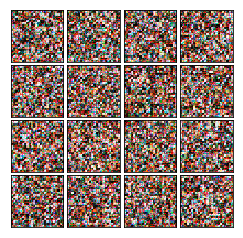

In [29]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 1.0})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])

### Train model with lr=0.005

In [30]:
utils.trainer(
    sess, 
    num_steps=10000, 
    train_op=train_op, 
    feed_dict_fn=lambda: {lr_ph: 0.005, beta_ph: 1.0}, 
    metrics=[metrics], 
    hooks=[plot_metrics_hook]
)

In [31]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 1.0})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])

### Train model with lr=0.001

In [32]:
utils.trainer(
    sess, 
    num_steps=10000, 
    train_op=train_op, 
    feed_dict_fn=lambda: {lr_ph: 0.001, beta_ph: 1.}, 
    metrics=[metrics], 
    hooks=[plot_metrics_hook]
)

In [33]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 0.6})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])

### Train model with lr=0.0001

In [34]:
utils.trainer(
    sess, 
    num_steps=10000, 
    train_op=train_op, 
    feed_dict_fn=lambda: {lr_ph: 0.0001, beta_ph: 1.}, 
    metrics=[metrics], 
    hooks=[plot_metrics_hook]
)

In [44]:
x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: 0.7})
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])

### Long train ...

In [ ]:
utils.trainer(
    sess, 
    num_steps=100000, 
    train_op=train_op, 
    feed_dict_fn=lambda: {lr_ph: 0.0001, beta_ph: 1.}, 
    metrics=[metrics], 
    hooks=[plot_metrics_hook]
)

  0%|          | 100/100000 [00:10<2:50:12,  9.78it/s]

total_loss -2515.47
loss -2517.224
l2_loss 1.7541755


  0%|          | 189/100000 [00:19<2:51:03,  9.73it/s]

## Generate samples for different temperatures

We start from zero T i.e. the input standard deviation is zero. We can see simialar 
conclusion as in paper, sampling from reduced temperature yield in better results.

In [105]:
for beta in np.linspace(0.0, 1.5, 10):
    print(f"beta={beta:10.4f}")
    x_samples_np = x_flow_sampled.eval(feed_dict={lr_ph: 0.0, beta_ph: beta})
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])
    plt.show()
    

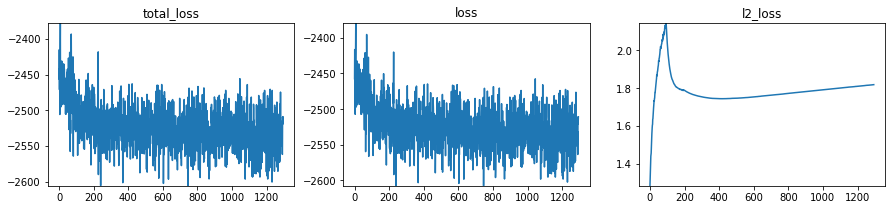

In [70]:
plot_metrics_hook.run()

## Investigate latent space statistics
Check whether the distribution of the latent variables fits the prior distribution. We should observe gaussian

In [79]:
y_flatten_np = np.concatenate([y_flatten.eval({lr_ph: 0.0, beta_ph: 1.0}) for i in range(100)])
y_flatten_np.shape

(3200, 72)

### 2D scatter plot for 0-th and 1-st latent variable

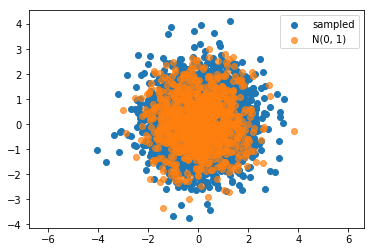

In [89]:
plt.scatter(y_flatten_np[:, 0], y_flatten_np[:, 1], label="sampled")
plt.scatter(*np.random.randn(2, 1000), alpha=0.7, label="N(0, 1)")
plt.axis("equal")
plt.legend()

### Histogram of all activations of Y latent variable

(-4, 4)

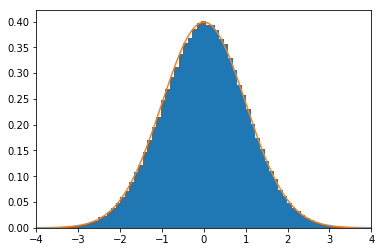

In [101]:
_ = plt.hist(y_flatten_np.reshape([-1]), 100, density=True)
x_axis = np.arange(-4, 4, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.xlim([-4, 4])

### Histogram of all activations of Z latent variable

In [2]:
z_flatten_np = np.concatenate([z_flatten.eval({lr_ph: 0.0, beta_ph: 1.0}) for i in range(100)])
_ = plt.hist(z_flatten_np.reshape([-1]), 200, density=True)
x_axis = np.arange(-4, 4, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.xlim([-4, 4])

NameError: name 'np' is not defined

## Tuning temperature separatelly for Y and Z latent variables

This seems to generate the best results when the temperature of the distribution of the Z variable is close 
or equal zero. 

In [106]:
beta_y_ph = tf.placeholder(tf.float32, [])
beta_z_ph = tf.placeholder(tf.float32, [])
prior_y_prim = tfd.MultivariateNormalDiag(
    loc=tf.zeros_like(y_flatten), scale_diag=beta_y_ph * tf.ones_like(y_flatten))
prior_z_prim = tfd.MultivariateNormalDiag(
    loc=tf.zeros_like(z_flatten), scale_diag=beta_z_ph * tf.ones_like(z_flatten))

In [107]:
sample_y_flatten_prim = prior_y_prim.sample()
sample_y_prim = tf.reshape(sample_y_flatten_prim, y.shape.as_list())
sample_z_prim = tf.reshape(prior_z_prim.sample(), z.shape.as_list())
sampled_logdet_prim = prior_y_prim.log_prob(sample_y_flatten_prim)

In [108]:
inverse_flow_prim = sample_y_prim, sampled_logdet_prim, sample_z_prim
sampled_flow_prim = model_flow(inverse_flow_prim, forward=False)

FactorOutLayer/Backward/Scale3          : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormBiasLayer/Backward/              : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ChainLayer/Backward/                    : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormLayer/Backward/                  : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ChainLayer/Backward/Step5               : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
AffineCouplingLayer/Backward/           : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
InvertibleConv1x1Layer/Backward/        : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormScaleLayer/Backward/             : y=[32, 3, 3, 16]	z=[32, 3, 3, 48]	logdet=[32]
ActnormBiasLayer/Backward/      

In [111]:
x_flow_sampled_prim, _, _ = sampled_flow_prim

### Efect of the temperature on the Z latent variable

In [122]:
for beta in np.linspace(0.0, 1.0, 10):
    print(f"beta={beta:10.4f}")
    x_samples_np = x_flow_sampled_prim.eval(
        feed_dict={
            lr_ph: 0.0,
            beta_y_ph: 1.0, 
            beta_z_ph: beta
        }
    )
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])
    plt.show()
    

### Efect of the temperature on the Y latent variable when beta_z=0.1

In [123]:
for beta in np.linspace(0.0, 1.0, 10):
    print(f"beta={beta:10.4f}")
    x_samples_np = x_flow_sampled_prim.eval(
        feed_dict={
            lr_ph: 0.0,
            beta_y_ph: beta, 
            beta_z_ph: 0.1
        }
    )
    utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:4])
    plt.show()
    